In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [54]:
# Load the datasets
train_df = pd.read_csv('fraudTrain.csv')
test_df = pd.read_csv('fraudTest.csv')

print(f"Training dataset shape: {train_df.shape}")
print(f"Testing dataset shape: {test_df.shape}")
print(f"Training dataset columns: {list(train_df.columns)}")


Training dataset shape: (1296675, 23)
Testing dataset shape: (555719, 23)
Training dataset columns: ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']


# Loading Dataset and Visualization

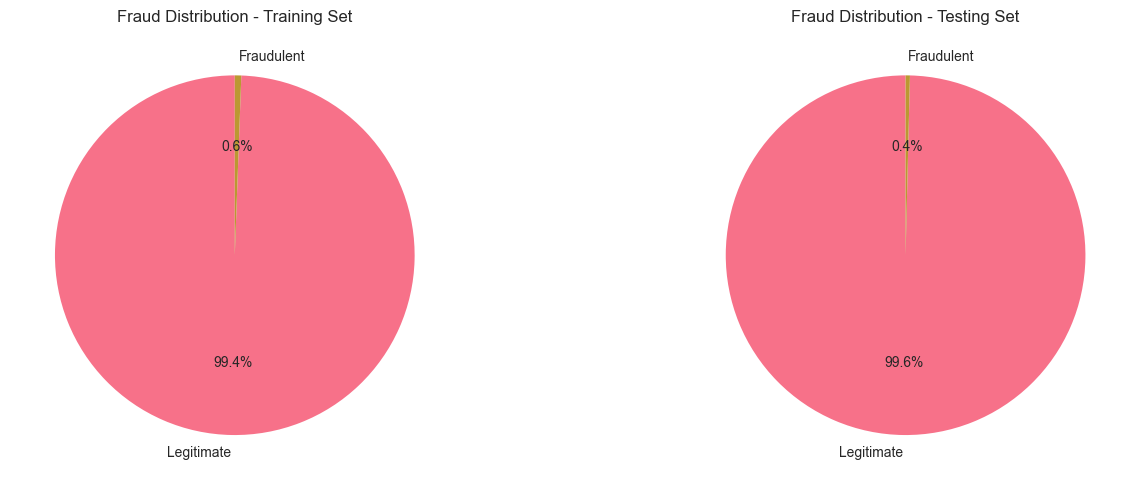


Fraud percentage in training set: 0.58%
Fraud percentage in testing set: 0.39%


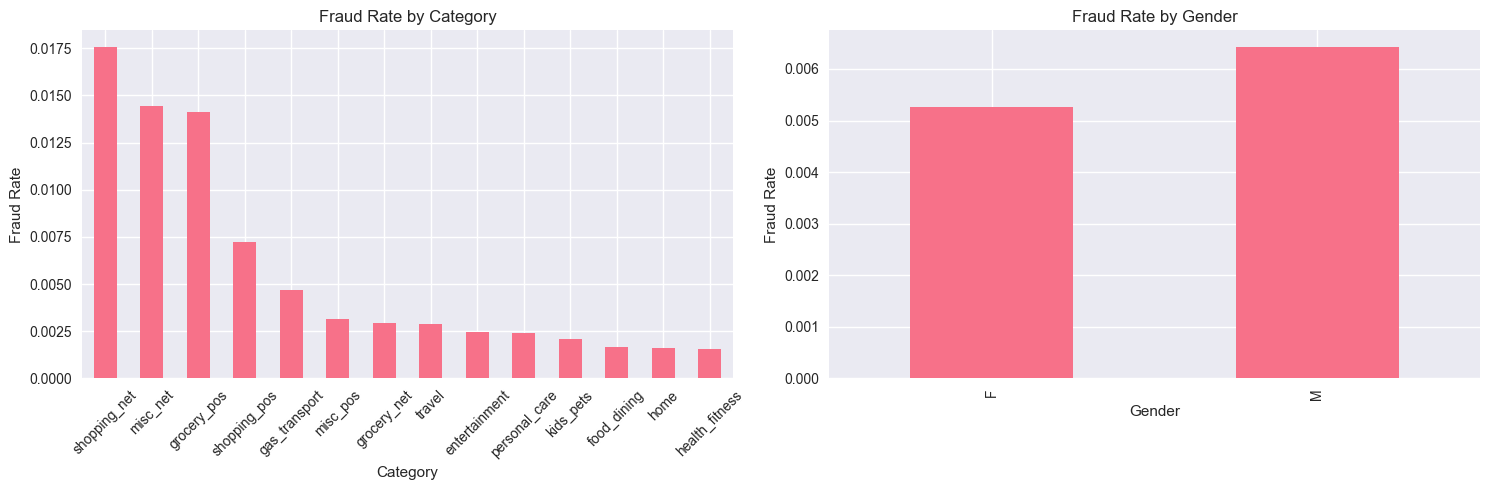

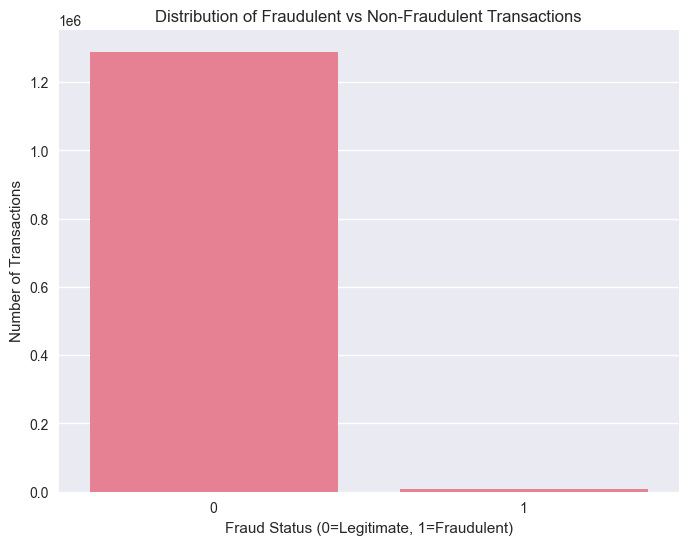

=== TRANSACTION AMOUNT STATISTICS ===
Mean amount for legitimate transactions: $67.67
Mean amount for fraudulent transactions: $531.32
Median amount for legitimate transactions: $47.28
Median amount for fraudulent transactions: $396.50


In [55]:
# Calculate fraud counts for training and testing datasets
fraud_counts_train = train_df['is_fraud'].value_counts()
fraud_counts_test = test_df['is_fraud'].value_counts()

# Visualize fraud distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set distribution
axes[0].pie(fraud_counts_train.values, labels=['Legitimate', 'Fraudulent'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Fraud Distribution - Training Set')

# Testing set distribution
axes[1].pie(fraud_counts_test.values, labels=['Legitimate', 'Fraudulent'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Fraud Distribution - Testing Set')

plt.tight_layout()
plt.show()

# Print fraud percentages
print(f"\nFraud percentage in training set: {train_df['is_fraud'].mean()*100:.2f}%")
print(f"Fraud percentage in testing set: {test_df['is_fraud'].mean()*100:.2f}%")

# Exploratory Data Analysis - Transaction Amounts
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Category distribution
category_fraud = train_df.groupby('category')['is_fraud'].mean().sort_values(ascending=False)
category_fraud.plot(kind='bar', ax=axes[0])
axes[0].set_title('Fraud Rate by Category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Fraud Rate')
axes[0].tick_params(axis='x', rotation=45)

# Gender distribution
gender_fraud = train_df.groupby('gender')['is_fraud'].mean()
gender_fraud.plot(kind='bar', ax=axes[1])
axes[1].set_title('Fraud Rate by Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Fraud Rate')

plt.tight_layout()
plt.show()

# Count plot for fraud distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=train_df, x='is_fraud')
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Fraud Status (0=Legitimate, 1=Fraudulent)')
plt.ylabel('Number of Transactions')
plt.show()

# Print transaction statistics
print("=== TRANSACTION AMOUNT STATISTICS ===")
print(f"Mean amount for legitimate transactions: ${train_df[train_df['is_fraud']==0]['amt'].mean():.2f}")
print(f"Mean amount for fraudulent transactions: ${train_df[train_df['is_fraud']==1]['amt'].mean():.2f}")
print(f"Median amount for legitimate transactions: ${train_df[train_df['is_fraud']==0]['amt'].median():.2f}")
print(f"Median amount for fraudulent transactions: ${train_df[train_df['is_fraud']==1]['amt'].median():.2f}")

# Feature Extraction

In [56]:
def engineer_features(df):
    df = df.copy()
    
    # Convert transaction date to datetime
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    
    # Extract time-based features
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    df['month'] = df['trans_date_trans_time'].dt.month
    df['day'] = df['trans_date_trans_time'].dt.day
    
    # Calculate age from date of birth
    df['dob'] = pd.to_datetime(df['dob'])
    df['age'] = (pd.Timestamp.now() - df['dob']).dt.days // 365
    
    # Calculate distance between customer and merchant
    df['distance'] = np.sqrt((df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2)
    
    # Log transform amount to handle skewness
    df['log_amt'] = np.log1p(df['amt'])
    
    # Create time-based features for fraud patterns
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_night'] = df['hour'].isin([22, 23, 0, 1, 2, 3, 4, 5]).astype(int)
    
    return df

# Apply feature engineering
train_df = engineer_features(train_df)
test_df = engineer_features(test_df)

print(f"New training dataset shape: {train_df.shape}")
print(f"New testing dataset shape: {test_df.shape}")


New training dataset shape: (1296675, 32)
New testing dataset shape: (555719, 32)


# Data Preprocessing

In [57]:
# Select features for modeling
categorical_features = ['category', 'gender', 'state']
numerical_features = ['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 
                     'hour', 'day_of_week', 'month', 'day', 'age', 'distance', 
                     'log_amt', 'is_weekend', 'is_night']

def preprocess_data(df, label_encoders=None, fit_encoders=True):
    df = df.copy()
    
    if label_encoders is None:
        label_encoders = {}
    
    # Encode categorical variables
    for feature in categorical_features:
        if fit_encoders:
            le = LabelEncoder()
            df[feature] = le.fit_transform(df[feature].astype(str))
            label_encoders[feature] = le
        else:
            if feature in label_encoders:
                # Handle unseen categories
                df[feature] = df[feature].astype(str)
                # Map known categories
                known_categories = set(label_encoders[feature].classes_)
                df[feature] = df[feature].apply(lambda x: x if x in known_categories else 'unknown')
                # Add 'unknown' category if not present
                if 'unknown' not in label_encoders[feature].classes_:
                    df[feature] = label_encoders[feature].transform(df[feature])
                else:
                    df[feature] = label_encoders[feature].transform(df[feature])
    
    # Select features
    features = categorical_features + numerical_features
    X = df[features]
    
    return X, label_encoders

# Preprocess training data
X_train, label_encoders = preprocess_data(train_df)
y_train = train_df['is_fraud']

# Preprocess testing data
X_test, _ = preprocess_data(test_df, label_encoders, fit_encoders=False)
y_test = test_df['is_fraud']

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Training features shape: (1296675, 18)
Testing features shape: (555719, 18)
Training target shape: (1296675,)
Testing target shape: (555719,)


# Model Training and Performance Evaluation

In [58]:
# Model Implementation and Training
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1)
}

# Train models and store results
model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for Logistic Regression, original for tree-based models
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    model_results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

print("\nModel training completed!")



Training Logistic Regression...
Logistic Regression - Accuracy: 0.9961, Precision: 0.4944, Recall: 0.0615, F1: 0.1095, AUC: 0.8867

Training Decision Tree...
Decision Tree - Accuracy: 0.9981, Precision: 0.7343, Recall: 0.7860, F1: 0.7593, AUC: 0.8925

Training Random Forest...
Random Forest - Accuracy: 0.9988, Precision: 0.9485, Recall: 0.7301, F1: 0.8251, AUC: 0.9767

Model training completed!


MODEL PERFORMANCE COMPARISON 
                 Model  Accuracy  Precision  Recall  F1-Score     AUC
0  Logistic Regression    0.9961     0.4944  0.0615    0.1095  0.8867
1        Decision Tree    0.9981     0.7343  0.7860    0.7593  0.8925
2        Random Forest    0.9988     0.9485  0.7301    0.8251  0.9767


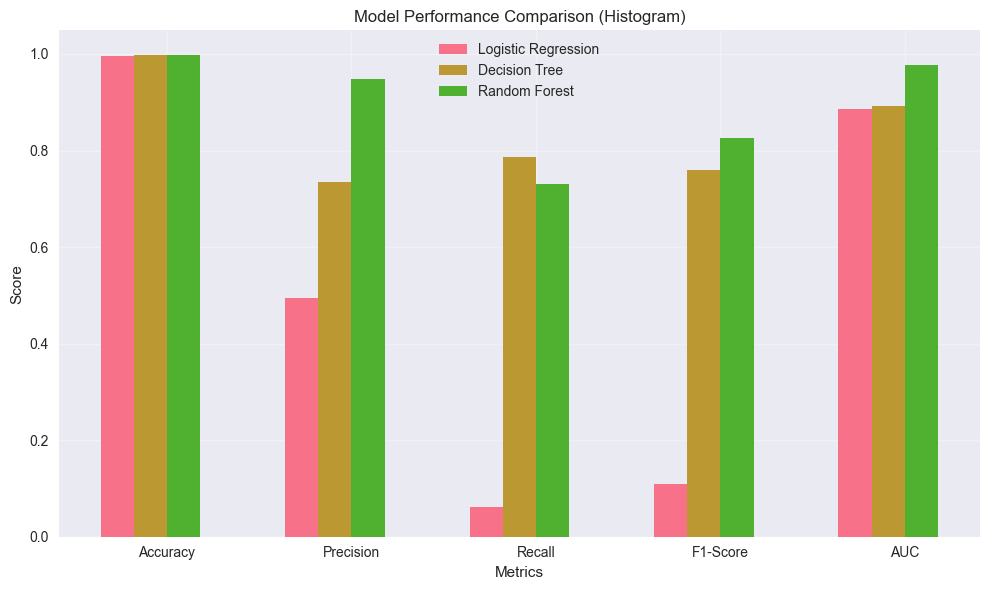

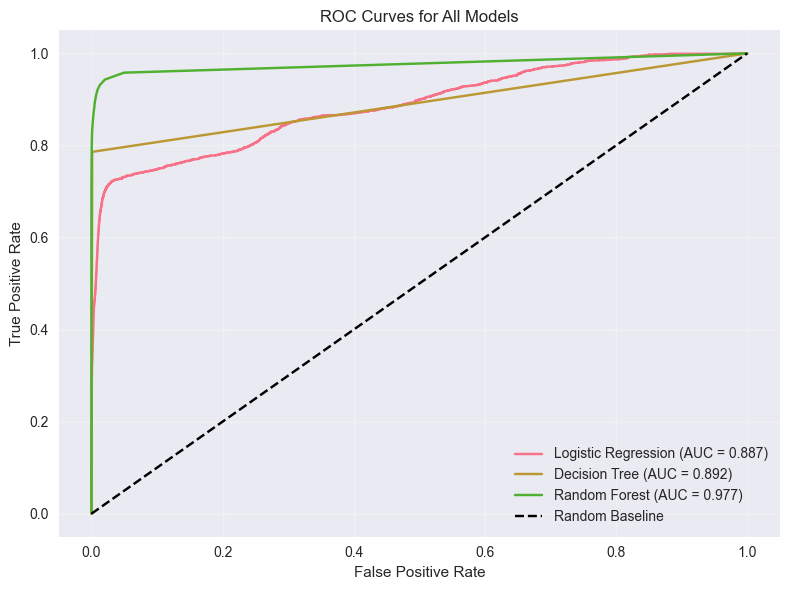

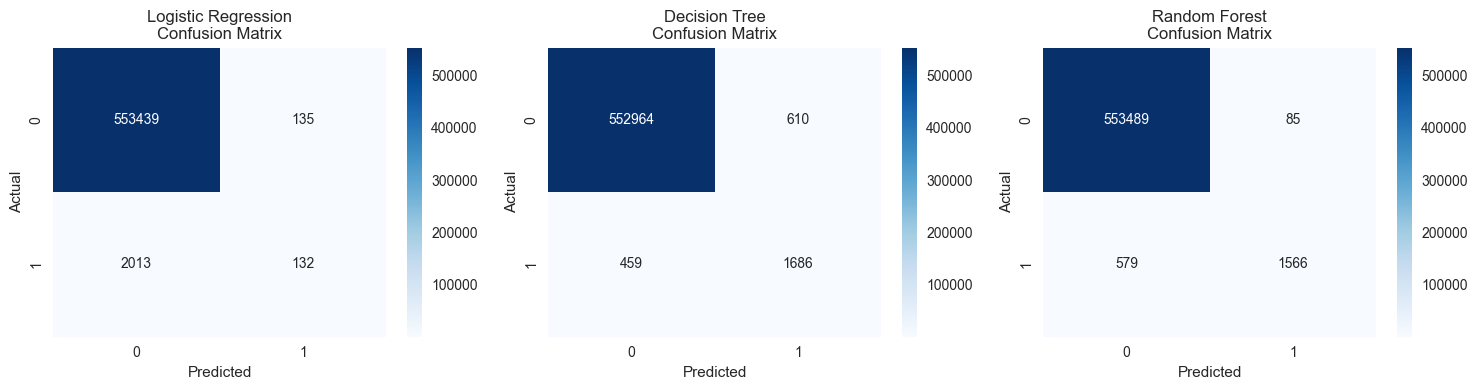

In [59]:
print("MODEL PERFORMANCE COMPARISON ")

# Create performance comparison DataFrame
performance_data = []
for model_name, results in model_results.items():
    performance_data.append({
        'Model': model_name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1_score'],
        'AUC': results['auc']
    })

performance_df = pd.DataFrame(performance_data)
print(performance_df.round(4))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(metrics))
width = 0.18

plt.figure(figsize=(10, 6))
for i, model_name in enumerate(performance_df['Model']):
    values = [performance_df.loc[i, metric] for metric in metrics]
    plt.bar(x + i*width, values, width, label=model_name)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison (Histogram)')
plt.xticks(x + width * (len(performance_df)/2), metrics)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for model_name, results in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {results["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(model_results), figsize=(15, 4))
for i, (model_name, results) in enumerate(model_results.items()):
    cm = confusion_matrix(y_test, results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{model_name}\nConfusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


# Predictions

In [60]:
def predict_fraud_random_forest(model, scaler, label_encoders, sample_data):
    # Make a copy of the sample data
    sample_df = sample_data.copy()
    
    # Apply the same feature engineering as training data
    def engineer_features(df):
        df = df.copy()
        
        # Convert transaction date to datetime
        df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
        
        # Extract time-based features
        df['hour'] = df['trans_date_trans_time'].dt.hour
        df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
        df['month'] = df['trans_date_trans_time'].dt.month
        df['day'] = df['trans_date_trans_time'].dt.day
        
        # Calculate age from date of birth
        df['dob'] = pd.to_datetime(df['dob'])
        df['age'] = (pd.Timestamp.now() - df['dob']).dt.days // 365
        
        # Calculate distance between customer and merchant
        df['distance'] = np.sqrt((df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2)
        
        # Log transform amount to handle skewness
        df['log_amt'] = np.log1p(df['amt'])
        
        # Create time-based features for fraud patterns
        df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
        df['is_night'] = df['hour'].isin([22, 23, 0, 1, 2, 3, 4, 5]).astype(int)
        
        return df
    
    # Apply feature engineering
    sample_df = engineer_features(sample_df)
    
    # Select features
    categorical_features = ['category', 'gender', 'state']
    numerical_features = ['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 
                         'hour', 'day_of_week', 'month', 'day', 'age', 'distance', 
                         'log_amt', 'is_weekend', 'is_night']
    
    # Encode categorical variables safely
    for feature in categorical_features:
        if feature in label_encoders:
            sample_df[feature] = sample_df[feature].astype(str)
            known_classes = set(label_encoders[feature].classes_)
            # Replace unknown categories with a placeholder that exists in encoder
            sample_df[feature] = sample_df[feature].apply(lambda x: x if x in known_classes else label_encoders[feature].classes_[0])
            sample_df[feature] = label_encoders[feature].transform(sample_df[feature])
    
    # Select features
    features = categorical_features + numerical_features
    X_sample = sample_df[features]
    
    # Scale numeric features
    X_sample_scaled = scaler.transform(X_sample)
    
    # Make predictions
    predictions = model.predict(X_sample_scaled)
    probabilities = model.predict_proba(X_sample_scaled)
    
    return predictions, probabilities

sample_data = pd.DataFrame({
    'trans_date_trans_time': ['2025-10-01 12:34:56', '2025-10-02 14:20:00', '2025-10-03 22:15:30', '2025-10-04 03:45:10', '2025-10-05 18:00:00'],
    'dob': ['1980-05-15', '1990-07-20', '1975-03-10', '2000-01-01', '1985-09-25'],
    'amt': [120.50, 250.00, 75.00, 500.00, 300.00],
    'category': ['grocery', 'entertainment', 'gas_transport', 'shopping_net', 'shopping_pos'],
    'gender': ['M', 'F', 'M', 'F', 'M'],
    'city': ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix'],
    'state': ['NY', 'CA', 'IL', 'TX', 'AZ'],
    'city_pop': [8400000, 4000000, 2700000, 2300000, 1600000],
    'lat': [40.7128, 34.0522, 41.8781, 29.7604, 33.4484],
    'long': [-74.0060, -118.2437, -87.6298, -95.3698, -112.0740],
    'merch_lat': [40.7130, 34.0525, 41.8785, 29.7608, 33.4488],
    'merch_long': [-74.0055, -118.2432, -87.6293, -95.3693, -112.0735]
})

# Ensure the data types are correct
sample_data['trans_date_trans_time'] = pd.to_datetime(sample_data['trans_date_trans_time'])
sample_data['dob'] = pd.to_datetime(sample_data['dob'])

# === Make Predictions for all 5 sample transactions ===
rf_model = None
for model_name, model in models.items():
    if 'Random Forest' in model_name:
        rf_model = model
        break

if rf_model is not None:
    predictions, probabilities = predict_fraud_random_forest(rf_model, scaler, label_encoders, sample_data)
    
    print("PREDICTION RESULTS:")
    print("="*50)
    
    # Print individual transaction results
    for i in range(len(sample_data)):
        print(f"\nTransaction {i+1}:")
        print(f"  Amount: ${sample_data.iloc[i]['amt']:.2f}")
        print(f"  Category: {sample_data.iloc[i]['category']}")
        print(f"  City: {sample_data.iloc[i]['city']}, {sample_data.iloc[i]['state']}")
        print(f"  Gender: {sample_data.iloc[i]['gender']}")
        print(f"  Prediction: {'FRAUD' if predictions[i] == 1 else 'LEGITIMATE'}")
        print(f"  Fraud Probability: {probabilities[i][1]:.4f} ({probabilities[i][1]*100:.2f}%)")
        print(f"  Legitimate Probability: {probabilities[i][0]:.4f} ({probabilities[i][0]*100:.2f}%)")
    
    # Print summary after all transactions
    print("\n" + "="*50)
    print(f"SUMMARY:")
    print(f"Total transactions analyzed: {len(sample_data)}")
    print(f"Predicted as FRAUD: {sum(predictions)}")
    print(f"Predicted as LEGITIMATE: {len(predictions) - sum(predictions)}")
else:
    print("Random Forest model not found in the trained models!")

PREDICTION RESULTS:

Transaction 1:
  Amount: $120.50
  Category: grocery
  City: New York, NY
  Gender: M
  Prediction: LEGITIMATE
  Fraud Probability: 0.2100 (21.00%)
  Legitimate Probability: 0.7900 (79.00%)

Transaction 2:
  Amount: $250.00
  Category: entertainment
  City: Los Angeles, CA
  Gender: F
  Prediction: LEGITIMATE
  Fraud Probability: 0.2200 (22.00%)
  Legitimate Probability: 0.7800 (78.00%)

Transaction 3:
  Amount: $75.00
  Category: gas_transport
  City: Chicago, IL
  Gender: M
  Prediction: LEGITIMATE
  Fraud Probability: 0.2500 (25.00%)
  Legitimate Probability: 0.7500 (75.00%)

Transaction 4:
  Amount: $500.00
  Category: shopping_net
  City: Houston, TX
  Gender: F
  Prediction: LEGITIMATE
  Fraud Probability: 0.3200 (32.00%)
  Legitimate Probability: 0.6800 (68.00%)

Transaction 5:
  Amount: $300.00
  Category: shopping_pos
  City: Phoenix, AZ
  Gender: M
  Prediction: LEGITIMATE
  Fraud Probability: 0.2400 (24.00%)
  Legitimate Probability: 0.7600 (76.00%)

SUM